In [1]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype # This one only to get rid of the annoying xgboost warning
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from cmcrameri import cm
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import tables
import sage

plt.style.use('seaborn-v0_8-dark')

C:\Users\forraust\Anaconda3\envs\regmarket-paper\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def sage_calc(x_sage,y_sage,feature_names, model_sage):
    x_sage = np.array(x_sage)
    y_sage = np.array(y_sage)
    chosen_idx = np.random.choice(len(y_test), replace=False, size=200)
    #print(np.shape(x_sage))
    #print(np.count_nonzero(np.isnan(x_sage)),np.count_nonzero(np.isnan(y_sage)))
    # Set up an imputer to handle missing features
    imputer = sage.MarginalImputer(model_sage, x_sage[:12])
    #print(np.shape(x_sage[0:1].flatten()))
    #imputer = sage.DefaultImputer(model_sage, x_sage[0:1].flatten())

    # Set up an estimator
    estimator = sage.PermutationEstimator(imputer, 'mse')

    # Calculate SAGE values
    sage_values = estimator(x_sage, y_sage)
    sage_values.plot(feature_names,max_features=30,error_bars=False)
    return sage_values

# Read data

In [3]:
#df = pd.read_csv("dataset_timeseries.csv",index_col=[0])
df = pd.read_hdf('nordpool_2016-01-01_2022-11-30.h5').ffill()
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['day'] = df.index.dayofweek
df['hour'] = df.index.hour

df.index = pd.to_datetime(df.index)
# display(df)

regulation_zones = ["regulations_NO1","regulations_NO2", "regulations_NO3", "regulations_NO4", 
                    "regulations_NO5", "regulations_SE1", "regulations_SE2", "regulations_SE3",
                    "regulations_DK1", "regulations_FI"] 
reg_zones_new = ["NO1 regulation volume","NO2 regulation volume", "NO3 regulation volume", "NO4 regulation volume", "NO5 regulation volume", 
                 "SE1 regulation volume", "SE2 regulation volume", "SE3 regulation volume", "DK1 regulation volume", "FI regulation volume"] 
im_volumes_df = df.loc[: , regulation_zones].copy()
im_volumes_df.columns = reg_zones_new
im_volumes = im_volumes_df.to_numpy()
# display(im_volumes_df)

# Knowing t, t-4, t-5, t-6 for dayahead and t-4, t-5, t-6 for regulation volume

We construct a dataset with all zones DA sell and buy volumes at t and t-4, regulation market volume for t-4 and month,weekday,day,hour,business-day for t. 

We try fitting on the whole dataset and individual years. Train-test split is SHUFFLED

Barplot shows the scores for the different models in different zones.

In [4]:
X = df.copy()

X = X[['day_ahead_prices_NO1','day_ahead_prices_NO2','day_ahead_prices_NO3',
       'day_ahead_prices_NO4','day_ahead_prices_NO5',
       'regulations_NO1','regulations_NO2','regulations_NO3','regulations_NO4','regulations_NO5',
       'year','month','day','hour',
      'day_ahead_sell_NO1','day_ahead_sell_NO2','day_ahead_sell_NO3',
       'day_ahead_sell_NO4','day_ahead_sell_NO5',
      'day_ahead_buy_NO1','day_ahead_buy_NO2','day_ahead_buy_NO3',
      'day_ahead_buy_NO4','day_ahead_buy_NO5']]


for i in range(1,6):    
    X[f'day_ahead_prices_NO{i}+1'] = X[f'day_ahead_prices_NO{i}'].shift(-1)
    X[f'day_ahead_prices_NO{i}+2'] = X[f'day_ahead_prices_NO{i}'].shift(-2)
    X[f'day_ahead_prices_NO{i}+3'] = X[f'day_ahead_prices_NO{i}'].shift(-3)
    X[f'day_ahead_prices_NO{i}-1'] = X[f'day_ahead_prices_NO{i}'].shift(1)
    X[f'day_ahead_prices_NO{i}-2'] = X[f'day_ahead_prices_NO{i}'].shift(2)
    X[f'day_ahead_prices_NO{i}-3'] = X[f'day_ahead_prices_NO{i}'].shift(3)

    X[f'day_ahead_sell_NO{i}+1'] = X[f'day_ahead_sell_NO{i}'].shift(-1)
    X[f'day_ahead_sell_NO{i}+2'] = X[f'day_ahead_sell_NO{i}'].shift(-2)
    X[f'day_ahead_sell_NO{i}+3'] = X[f'day_ahead_sell_NO{i}'].shift(-3)
    X[f'day_ahead_sell_NO{i}-1'] = X[f'day_ahead_sell_NO{i}'].shift(1)
    X[f'day_ahead_sell_NO{i}-2'] = X[f'day_ahead_sell_NO{i}'].shift(2)
    X[f'day_ahead_sell_NO{i}-3'] = X[f'day_ahead_sell_NO{i}'].shift(3)

    X[f'day_ahead_buy_NO{i}+1'] = X[f'day_ahead_buy_NO{i}'].shift(-1)
    X[f'day_ahead_buy_NO{i}+2'] = X[f'day_ahead_buy_NO{i}'].shift(-2)
    X[f'day_ahead_buy_NO{i}+3'] = X[f'day_ahead_buy_NO{i}'].shift(-3)
    X[f'day_ahead_buy_NO{i}-1'] = X[f'day_ahead_buy_NO{i}'].shift(1)
    X[f'day_ahead_buy_NO{i}-2'] = X[f'day_ahead_buy_NO{i}'].shift(2)
    X[f'day_ahead_buy_NO{i}-3'] = X[f'day_ahead_buy_NO{i}'].shift(3)
    
    # t-4 for regulation market
    X[f'regulations_NO{i}-4'] = df[f'regulations_NO{i}'].shift(4)
    X[f'regulations_NO{i}-5'] = df[f'regulations_NO{i}'].shift(5)
    X[f'regulations_NO{i}-6'] = df[f'regulations_NO{i}'].shift(6)

X = X.dropna()
y = X[['regulations_NO1','regulations_NO2','regulations_NO3',
       'regulations_NO4','regulations_NO5']].copy()

C:\Users\forraust\AppData\Local\Temp\ipykernel_28764\3996566380.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'day_ahead_buy_NO{i}+3'] = X[f'day_ahead_buy_NO{i}'].shift(-3)
C:\Users\forraust\AppData\Local\Temp\ipykernel_28764\3996566380.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'day_ahead_buy_NO{i}-1'] = X[f'day_ahead_buy_NO{i}'].shift(1)
C:\Users\forraust\AppData\Local\Temp\ipykernel_28764\3996566380.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

------------Zone: regulations_NO1-------------
0.5006517413756674


  2%|▏         | 0.0217/1 [00:04<03:15, 199.81s/it]

Modified


  5%|▍         | 0.0482/1 [00:08<02:53, 181.80s/it]

Modified


  6%|▌         | 0.0617/1 [00:13<03:25, 219.29s/it]

Modified


  8%|▊         | 0.0844/1 [00:17<03:14, 212.19s/it]

Modified


 11%|█         | 0.1065/1 [00:22<03:06, 208.57s/it]

Modified


 13%|█▎        | 0.1349/1 [00:27<02:53, 200.69s/it]

Modified


 15%|█▌        | 0.1538/1 [00:31<02:54, 206.10s/it]

Modified


 16%|█▋        | 0.1631/1 [00:36<03:05, 221.11s/it]

Modified


 18%|█▊        | 0.182/1 [00:40<03:01, 222.27s/it] 

Modified


 20%|█▉        | 0.1993/1 [00:45<03:02, 227.64s/it]

Modified


 22%|██▏       | 0.2238/1 [00:49<02:53, 223.02s/it]

Modified


 24%|██▍       | 0.2386/1 [00:54<02:53, 228.50s/it]

Modified


 25%|██▌       | 0.2547/1 [00:59<02:53, 233.00s/it]

Modified


 27%|██▋       | 0.2703/1 [01:03<02:52, 236.50s/it]

Modified


 29%|██▊       | 0.2864/1 [01:08<02:50, 238.94s/it]

Modified


 30%|███       | 0.3029/1 [01:12<02:47, 240.84s/it]

Modified


 32%|███▏      | 0.3167/1 [01:17<02:48, 246.08s/it]

Modified


 34%|███▍      | 0.3398/1 [01:22<02:39, 242.28s/it]

Modified


 36%|███▌      | 0.3615/1 [01:26<02:33, 240.10s/it]

Modified


 38%|███▊      | 0.3797/1 [01:31<02:29, 241.69s/it]

Modified


 40%|███▉      | 0.3963/1 [01:36<02:26, 243.06s/it]

Modified


 41%|████▏     | 0.4148/1 [01:40<02:22, 243.09s/it]

Modified


 43%|████▎     | 0.4348/1 [01:45<02:17, 242.51s/it]

Modified


 45%|████▍     | 0.4469/1 [01:50<02:16, 246.47s/it]

Modified


 47%|████▋     | 0.4725/1 [01:54<02:07, 242.63s/it]

Modified


 49%|████▉     | 0.4895/1 [01:59<02:04, 243.13s/it]

Modified


 50%|█████     | 0.5006/1 [02:03<02:03, 247.55s/it]

Modified


 52%|█████▏    | 0.5233/1 [02:08<01:56, 245.17s/it]

Modified


 54%|█████▍    | 0.5437/1 [02:12<01:51, 244.33s/it]

Modified


 56%|█████▌    | 0.5552/1 [02:17<01:50, 247.61s/it]

Modified


 57%|█████▋    | 0.5668/1 [02:22<01:48, 251.04s/it]

Modified


 59%|█████▉    | 0.5899/1 [02:26<01:41, 248.64s/it]

Modified


 60%|██████    | 0.6001/1 [02:31<01:40, 251.73s/it]

Modified


 62%|██████▏   | 0.621/1 [02:36<01:35, 251.43s/it] 

Modified


 64%|██████▍   | 0.6382/1 [02:40<01:31, 251.72s/it]

Modified


 66%|██████▋   | 0.6628/1 [02:45<01:24, 249.11s/it]

Modified


 68%|██████▊   | 0.6842/1 [02:49<01:18, 248.28s/it]

Modified


 69%|██████▉   | 0.6944/1 [02:54<01:16, 251.34s/it]

Modified


 71%|███████   | 0.7082/1 [02:58<01:13, 252.69s/it]

Modified


 73%|███████▎  | 0.7264/1 [03:03<01:09, 252.47s/it]

Modified


 75%|███████▍  | 0.7451/1 [03:08<01:04, 252.73s/it]

Modified


 77%|███████▋  | 0.7661/1 [03:12<00:58, 251.42s/it]

Modified


 78%|███████▊  | 0.7763/1 [03:17<00:56, 253.84s/it]

Modified


 81%|████████  | 0.8053/1 [03:21<00:48, 250.56s/it]

Modified


 83%|████████▎ | 0.8275/1 [03:26<00:43, 249.46s/it]

Modified


 84%|████████▍ | 0.8435/1 [03:30<00:39, 249.95s/it]

Modified


 85%|████████▌ | 0.8512/1 [03:35<00:37, 252.89s/it]

Modified


 87%|████████▋ | 0.8702/1 [03:40<00:32, 253.13s/it]

Modified


 88%|████████▊ | 0.883/1 [03:44<00:29, 254.55s/it] 

Modified


 90%|████████▉ | 0.8998/1 [03:49<00:25, 254.71s/it]

Modified


 92%|█████████▏| 0.9241/1 [03:53<00:19, 253.12s/it]

Modified


 93%|█████████▎| 0.9327/1 [03:58<00:17, 255.81s/it]

Modified


 96%|█████████▋| 0.9627/1 [04:02<00:09, 252.40s/it]

Modified


 98%|█████████▊| 0.9821/1 [04:07<00:04, 251.93s/it]

Modified


 99%|█████████▉| 0.992/1 [04:12<00:02, 254.29s/it] 

Modified


100%|██████████| 1/1 [04:16<00:00, 256.78s/it]    


Modified
Modified
------------Zone: regulations_NO2-------------
0.4995416817596958


  1%|          | 0.0103/1 [00:05<08:18, 503.51s/it]

Modified


  2%|▏         | 0.0209/1 [00:09<07:33, 462.75s/it]

Modified


  3%|▎         | 0.0302/1 [00:14<07:39, 474.08s/it]

Modified


  4%|▎         | 0.0351/1 [00:19<08:51, 550.33s/it]

Modified


  4%|▍         | 0.0432/1 [00:24<08:56, 560.33s/it]

Modified


  5%|▌         | 0.0528/1 [00:28<08:39, 548.68s/it]

Modified


  6%|▋         | 0.0641/1 [00:33<08:14, 527.95s/it]

Modified


  7%|▋         | 0.0737/1 [00:39<08:11, 530.74s/it]

Modified


  9%|▊         | 0.0857/1 [00:44<07:49, 513.52s/it]

Modified


 10%|▉         | 0.0966/1 [00:48<07:36, 504.83s/it]

Modified


 11%|█▏        | 0.1138/1 [00:54<07:01, 476.14s/it]

Modified


 12%|█▏        | 0.122/1 [00:59<07:04, 483.64s/it] 

Modified


 13%|█▎        | 0.1269/1 [01:03<07:19, 503.77s/it]

Modified


 14%|█▍        | 0.1389/1 [01:09<07:09, 498.45s/it]

Modified


 15%|█▌        | 0.1525/1 [01:13<06:50, 484.85s/it]

Modified


 16%|█▌        | 0.161/1 [01:18<06:49, 488.67s/it] 

Modified


 16%|█▌        | 0.1597/1 [01:23<07:21, 525.29s/it]

Modified


 17%|█▋        | 0.1723/1 [01:28<07:05, 514.44s/it]

Modified


 18%|█▊        | 0.1795/1 [01:33<07:07, 520.78s/it]

Modified


 19%|█▊        | 0.1865/1 [01:38<07:09, 527.64s/it]

Modified


 20%|██        | 0.2035/1 [01:43<06:45, 509.04s/it]

Modified


 21%|██▏       | 0.2142/1 [01:48<06:38, 506.59s/it]

Modified


 22%|██▏       | 0.2215/1 [01:53<06:38, 511.50s/it]

Modified


 23%|██▎       | 0.2303/1 [01:58<06:37, 516.09s/it]

Modified


 24%|██▍       | 0.2383/1 [02:04<06:37, 521.75s/it]

Modified


 25%|██▍       | 0.2484/1 [02:09<06:31, 520.64s/it]

Modified


 25%|██▌       | 0.2549/1 [02:15<06:34, 529.82s/it]

Modified


 27%|██▋       | 0.2651/1 [02:20<06:28, 528.92s/it]

Modified


 27%|██▋       | 0.2733/1 [02:25<06:25, 531.04s/it]

Modified


 29%|██▊       | 0.2862/1 [02:30<06:15, 526.73s/it]

Modified


 29%|██▉       | 0.2937/1 [02:35<06:14, 530.15s/it]

Modified


 30%|███       | 0.3018/1 [02:40<06:11, 532.25s/it]

Modified


 32%|███▏      | 0.3171/1 [02:46<05:58, 524.29s/it]

Modified


 33%|███▎      | 0.3257/1 [02:51<05:54, 525.62s/it]

Modified


 34%|███▎      | 0.3352/1 [02:56<05:49, 525.46s/it]

Modified


 34%|███▍      | 0.3428/1 [03:01<05:48, 529.75s/it]

Modified


 36%|███▌      | 0.3555/1 [03:06<05:37, 524.08s/it]

Modified


 37%|███▋      | 0.3664/1 [03:11<05:30, 521.62s/it]

Modified


 38%|███▊      | 0.3827/1 [03:16<05:16, 513.49s/it]

Modified


 39%|███▉      | 0.3929/1 [03:21<05:11, 512.71s/it]

Modified


 41%|████      | 0.4082/1 [03:26<04:59, 506.22s/it]

Modified


 42%|████▏     | 0.4209/1 [03:32<04:51, 503.85s/it]

Modified


 43%|████▎     | 0.4283/1 [03:37<04:50, 507.91s/it]

Modified


 44%|████▍     | 0.4378/1 [03:42<04:45, 508.23s/it]

Modified


 45%|████▍     | 0.4467/1 [03:47<04:42, 510.19s/it]

Modified


 46%|████▌     | 0.457/1 [03:52<04:36, 509.22s/it] 

Modified


 47%|████▋     | 0.4652/1 [03:57<04:32, 509.69s/it]

Modified


 48%|████▊     | 0.475/1 [04:01<04:26, 508.07s/it] 

Modified


 48%|████▊     | 0.4845/1 [04:06<04:22, 508.71s/it]

Modified


 49%|████▉     | 0.4944/1 [04:10<04:16, 507.04s/it]

Modified


 51%|█████     | 0.5064/1 [04:14<04:08, 503.38s/it]

Modified


 52%|█████▏    | 0.5165/1 [04:19<04:02, 502.47s/it]

Modified


 53%|█████▎    | 0.5303/1 [04:24<03:54, 498.50s/it]

Modified


 53%|█████▎    | 0.5336/1 [04:28<03:54, 503.48s/it]

Modified


 55%|█████▍    | 0.5451/1 [04:33<03:47, 500.87s/it]

Modified


 55%|█████▌    | 0.5532/1 [04:38<03:44, 502.85s/it]

Modified


 57%|█████▋    | 0.5695/1 [04:42<03:33, 495.88s/it]

Modified


 59%|█████▊    | 0.5866/1 [04:46<03:21, 488.62s/it]

Modified


 59%|█████▉    | 0.5941/1 [04:51<03:18, 490.12s/it]

Modified


 61%|██████    | 0.6114/1 [04:56<03:08, 484.32s/it]

Modified


 62%|██████▏   | 0.6208/1 [05:00<03:03, 483.64s/it]

Modified


 63%|██████▎   | 0.6334/1 [05:04<02:56, 480.55s/it]

Modified


 64%|██████▍   | 0.6394/1 [05:09<02:54, 483.79s/it]

Modified


 65%|██████▍   | 0.6476/1 [05:13<02:50, 484.34s/it]

Modified


 65%|██████▌   | 0.6542/1 [05:17<02:48, 485.98s/it]

Modified


 67%|██████▋   | 0.6673/1 [05:22<02:40, 483.02s/it]

Modified


 68%|██████▊   | 0.6781/1 [05:27<02:35, 482.66s/it]

Modified


 69%|██████▊   | 0.687/1 [05:31<02:31, 482.57s/it] 

Modified


 70%|███████   | 0.7019/1 [05:35<02:22, 478.34s/it]

Modified


 72%|███████▏  | 0.715/1 [05:40<02:15, 476.28s/it] 

Modified


 73%|███████▎  | 0.7262/1 [05:45<02:10, 475.43s/it]

Modified


 74%|███████▍  | 0.7379/1 [05:49<02:04, 473.63s/it]

Modified


 74%|███████▍  | 0.7425/1 [05:53<02:02, 476.31s/it]

Modified


 75%|███████▌  | 0.7512/1 [05:58<01:58, 477.87s/it]

Modified


 76%|███████▌  | 0.7593/1 [06:03<01:55, 478.95s/it]

Modified


 77%|███████▋  | 0.7695/1 [06:08<01:50, 478.76s/it]

Modified


 78%|███████▊  | 0.7769/1 [06:13<01:47, 480.94s/it]

Modified


 79%|███████▉  | 0.7883/1 [06:18<01:41, 480.15s/it]

Modified


 80%|████████  | 0.8004/1 [06:23<01:35, 479.01s/it]

Modified


 81%|████████  | 0.8084/1 [06:28<01:32, 480.50s/it]

Modified


 82%|████████▏ | 0.8152/1 [06:33<01:29, 482.48s/it]

Modified


 82%|████████▎ | 0.825/1 [06:38<01:24, 482.50s/it] 

Modified


 84%|████████▎ | 0.8374/1 [06:42<01:18, 481.23s/it]

Modified


 85%|████████▍ | 0.8488/1 [06:48<01:12, 480.71s/it]

Modified


 86%|████████▌ | 0.8608/1 [06:52<01:06, 479.48s/it]

Modified


 88%|████████▊ | 0.8775/1 [06:57<00:58, 475.69s/it]

Modified


 89%|████████▊ | 0.8855/1 [07:02<00:54, 477.24s/it]

Modified


 90%|████████▉ | 0.8954/1 [07:07<00:49, 477.21s/it]

Modified


 91%|█████████ | 0.906/1 [07:12<00:44, 476.99s/it] 

Modified


 91%|█████████ | 0.9068/1 [07:17<00:44, 482.67s/it]

Modified


 91%|█████████ | 0.9079/1 [07:22<00:44, 487.23s/it]

Modified


 92%|█████████▏| 0.9184/1 [07:26<00:39, 486.69s/it]

Modified


 93%|█████████▎| 0.9324/1 [07:32<00:32, 484.86s/it]

Modified


 94%|█████████▍| 0.9445/1 [07:37<00:26, 483.86s/it]

Modified


 96%|█████████▌| 0.9554/1 [07:45<00:21, 487.14s/it]

Modified


 97%|█████████▋| 0.9666/1 [07:54<00:16, 490.79s/it]

Modified


 98%|█████████▊| 0.9771/1 [08:05<00:11, 496.55s/it]

Modified


 99%|█████████▉| 0.9895/1 [08:17<00:05, 502.88s/it]

Modified


100%|██████████| 1/1 [08:26<00:00, 506.47s/it]     

Modified
Modified
------------Zone: regulations_NO3-------------


0.5646976079315001


  2%|▏         | 0.023/1 [00:04<02:55, 179.24s/it]

Modified


  3%|▎         | 0.0318/1 [00:11<05:45, 357.24s/it]

Modified


  4%|▍         | 0.0376/1 [00:18<07:50, 488.48s/it]

Modified


  5%|▍         | 0.0496/1 [00:26<08:27, 534.20s/it]

Modified


  6%|▌         | 0.0554/1 [00:34<09:40, 614.86s/it]

Modified


  7%|▋         | 0.0696/1 [00:40<09:00, 580.90s/it]

Modified


  8%|▊         | 0.0834/1 [00:45<08:24, 550.05s/it]

Modified


  9%|▉         | 0.0926/1 [00:50<08:12, 542.64s/it]

Modified


 10%|█         | 0.1034/1 [00:54<07:52, 527.51s/it]

Modified


 12%|█▏        | 0.1194/1 [00:59<07:20, 500.58s/it]

Modified


 13%|█▎        | 0.1254/1 [01:03<07:26, 510.24s/it]

Modified


 13%|█▎        | 0.1327/1 [01:08<07:26, 514.28s/it]

Modified


 15%|█▍        | 0.1469/1 [01:13<07:04, 497.22s/it]

Modified


 16%|█▌        | 0.1575/1 [01:17<06:56, 494.83s/it]

Modified


 17%|█▋        | 0.1688/1 [01:22<06:44, 486.23s/it]

Modified


 18%|█▊        | 0.1789/1 [01:26<06:35, 482.18s/it]

Modified


 19%|█▉        | 0.1885/1 [01:31<06:33, 484.39s/it]

Modified


 20%|█▉        | 0.197/1 [01:36<06:31, 487.59s/it] 

Modified


 21%|██        | 0.2073/1 [01:40<06:25, 485.71s/it]

Modified


 22%|██▏       | 0.2172/1 [01:45<06:21, 486.81s/it]

Modified


 23%|██▎       | 0.2288/1 [01:50<06:12, 483.44s/it]

Modified


 24%|██▍       | 0.2394/1 [01:55<06:06, 482.40s/it]

Modified


 25%|██▌       | 0.2508/1 [02:00<06:00, 480.91s/it]

Modified


 26%|██▌       | 0.2572/1 [02:05<06:03, 488.84s/it]

Modified


 27%|██▋       | 0.2696/1 [02:10<05:53, 484.13s/it]

Modified


 29%|██▊       | 0.2856/1 [02:15<05:38, 473.13s/it]

Modified


 29%|██▉       | 0.2921/1 [02:20<05:40, 480.35s/it]

Modified


 31%|███       | 0.308/1 [02:25<05:26, 471.10s/it] 

Modified


 32%|███▏      | 0.3213/1 [02:30<05:18, 469.15s/it]

Modified


 33%|███▎      | 0.327/1 [02:37<05:23, 480.12s/it] 

Modified


 34%|███▎      | 0.3352/1 [02:42<05:22, 485.85s/it]

Modified


 35%|███▌      | 0.3503/1 [02:48<05:12, 480.52s/it]

Modified


 37%|███▋      | 0.3659/1 [02:54<05:02, 477.67s/it]

Modified


 37%|███▋      | 0.3743/1 [02:59<05:00, 480.77s/it]

Modified


 38%|███▊      | 0.3836/1 [03:05<04:57, 482.62s/it]

Modified


 38%|███▊      | 0.3786/1 [03:10<05:12, 502.70s/it]

Modified


 39%|███▉      | 0.3896/1 [03:16<05:08, 504.63s/it]

Modified


 41%|████      | 0.4061/1 [03:22<04:56, 498.48s/it]

Modified


 42%|████▏     | 0.4184/1 [03:27<04:48, 496.03s/it]

Modified


 42%|████▏     | 0.417/1 [03:32<04:57, 509.81s/it] 

Modified


 42%|████▏     | 0.4236/1 [03:38<04:56, 514.74s/it]

Modified


 44%|████▎     | 0.4357/1 [03:43<04:50, 514.02s/it]

Modified


 45%|████▍     | 0.4497/1 [03:49<04:40, 510.26s/it]

Modified


 46%|████▌     | 0.4588/1 [03:55<04:37, 512.80s/it]

Modified


 47%|████▋     | 0.4706/1 [04:00<04:30, 510.26s/it]

Modified


 48%|████▊     | 0.4847/1 [04:05<04:20, 506.01s/it]

Modified


 49%|████▉     | 0.4898/1 [04:10<04:21, 512.18s/it]

Modified


 50%|█████     | 0.5016/1 [04:16<04:14, 510.93s/it]

Modified


 51%|█████▏    | 0.5146/1 [04:21<04:06, 508.29s/it]

Modified


 53%|█████▎    | 0.5265/1 [04:27<04:00, 508.08s/it]

Modified


 53%|█████▎    | 0.5343/1 [04:32<03:57, 509.88s/it]

Modified


 55%|█████▍    | 0.5464/1 [04:37<03:50, 507.92s/it]

Modified


 55%|█████▌    | 0.554/1 [04:43<03:48, 511.42s/it] 

Modified


 57%|█████▋    | 0.5661/1 [04:48<03:41, 509.73s/it]

Modified


 58%|█████▊    | 0.5784/1 [04:54<03:34, 508.44s/it]

Modified


 60%|█████▉    | 0.5951/1 [05:00<03:24, 505.13s/it]

Modified


 60%|██████    | 0.6039/1 [05:06<03:20, 507.27s/it]

Modified


 61%|██████    | 0.6115/1 [05:11<03:18, 509.83s/it]

Modified


 62%|██████▏   | 0.6181/1 [05:17<03:16, 514.35s/it]

Modified


 63%|██████▎   | 0.6294/1 [05:23<03:10, 514.18s/it]

Modified


 65%|██████▍   | 0.6468/1 [05:29<02:59, 509.59s/it]

Modified


 65%|██████▌   | 0.6545/1 [05:35<02:57, 512.31s/it]

Modified


 67%|██████▋   | 0.6651/1 [05:40<02:51, 512.05s/it]

Modified


 67%|██████▋   | 0.6725/1 [05:46<02:48, 515.53s/it]

Modified


 68%|██████▊   | 0.684/1 [05:52<02:42, 515.39s/it] 

Modified


 69%|██████▉   | 0.692/1 [05:57<02:39, 516.95s/it]

Modified


 70%|███████   | 0.7044/1 [06:03<02:32, 516.63s/it]

Modified


 71%|███████   | 0.7123/1 [06:10<02:29, 519.64s/it]

Modified


 73%|███████▎  | 0.7268/1 [06:16<02:21, 518.03s/it]

Modified


 74%|███████▎  | 0.7358/1 [06:22<02:17, 520.40s/it]

Modified


 75%|███████▍  | 0.7468/1 [06:28<02:11, 519.71s/it]

Modified


 76%|███████▌  | 0.7577/1 [06:33<02:05, 519.41s/it]

Modified


 76%|███████▌  | 0.7581/1 [06:40<02:07, 528.30s/it]

Modified


 77%|███████▋  | 0.7708/1 [06:46<02:00, 527.66s/it]

Modified


 78%|███████▊  | 0.7801/1 [06:52<01:56, 528.69s/it]

Modified


 79%|███████▉  | 0.791/1 [06:57<01:50, 527.39s/it] 

Modified


 81%|████████  | 0.8082/1 [07:01<01:40, 521.94s/it]

Modified


 81%|████████  | 0.8096/1 [07:08<01:40, 529.12s/it]

Modified


 82%|████████▏ | 0.8213/1 [07:14<01:34, 529.19s/it]

Modified


 84%|████████▍ | 0.8377/1 [07:21<01:25, 526.54s/it]

Modified


 85%|████████▍ | 0.8494/1 [07:26<01:19, 525.86s/it]

Modified


 86%|████████▌ | 0.8595/1 [07:32<01:13, 526.05s/it]

Modified


 87%|████████▋ | 0.8669/1 [07:38<01:10, 529.21s/it]

Modified


 88%|████████▊ | 0.8783/1 [07:44<01:04, 528.79s/it]

Modified


 89%|████████▉ | 0.8885/1 [07:49<00:58, 528.50s/it]

Modified


 90%|█████████ | 0.9013/1 [07:55<00:52, 527.51s/it]

Modified


 91%|█████████ | 0.9077/1 [08:00<00:48, 529.31s/it]

Modified


 92%|█████████▏| 0.9192/1 [08:06<00:42, 529.24s/it]

Modified


 93%|█████████▎| 0.9326/1 [08:12<00:35, 527.89s/it]

Modified


 95%|█████████▍| 0.9485/1 [08:17<00:27, 524.48s/it]

Modified


 96%|█████████▋| 0.9629/1 [08:22<00:19, 521.68s/it]

Modified


 97%|█████████▋| 0.9692/1 [08:27<00:16, 524.10s/it]

Modified


 98%|█████████▊| 0.9788/1 [08:32<00:11, 523.55s/it]

Modified


 99%|█████████▉| 0.9912/1 [08:36<00:04, 521.22s/it]

Modified


100%|██████████| 1/1 [08:41<00:00, 521.62s/it]     

Modified
Modified
------------Zone: regulations_NO4-------------


0.5750164147110413


  1%|          | 0.0099/1 [00:05<08:25, 510.89s/it]

Modified


  2%|▏         | 0.0188/1 [00:09<08:31, 521.52s/it]

Modified


  3%|▎         | 0.0296/1 [00:14<07:53, 487.51s/it]

Modified


  4%|▎         | 0.037/1 [00:19<08:34, 533.83s/it] 

Modified


  4%|▍         | 0.0416/1 [00:24<09:24, 588.61s/it]

Modified


  5%|▍         | 0.049/1 [00:29<09:30, 599.52s/it] 

Modified


  6%|▌         | 0.0585/1 [00:33<09:06, 580.93s/it]

Modified


  6%|▋         | 0.0627/1 [00:39<09:53, 633.20s/it]

Modified


  7%|▋         | 0.071/1 [00:45<09:59, 644.79s/it] 

Modified


  8%|▊         | 0.0791/1 [00:51<09:57, 649.01s/it]

Modified


  9%|▊         | 0.0864/1 [00:56<10:01, 658.79s/it]

Modified


 10%|▉         | 0.0963/1 [01:01<09:33, 634.42s/it]

Modified


 10%|█         | 0.1041/1 [01:05<09:22, 628.07s/it]

Modified


 11%|█▏        | 0.1133/1 [01:10<09:10, 620.70s/it]

Modified


 12%|█▏        | 0.1162/1 [01:14<09:25, 640.39s/it]

Modified


 13%|█▎        | 0.1254/1 [01:18<09:07, 625.88s/it]

Modified


 14%|█▍        | 0.1382/1 [01:23<08:37, 601.01s/it]

Modified


 15%|█▍        | 0.1475/1 [01:27<08:25, 593.31s/it]

Modified


 16%|█▌        | 0.1571/1 [01:32<08:15, 587.85s/it]

Modified


 17%|█▋        | 0.1654/1 [01:36<08:06, 583.27s/it]

Modified


 17%|█▋        | 0.17/1 [01:41<08:15, 596.90s/it]  

Modified


 18%|█▊        | 0.1823/1 [01:46<07:55, 581.54s/it]

Modified


 19%|█▉        | 0.1905/1 [01:50<07:50, 581.58s/it]

Modified


 20%|█▉        | 0.1962/1 [01:55<07:54, 590.05s/it]

Modified


 21%|██        | 0.2059/1 [02:00<07:45, 586.20s/it]

Modified


 22%|██▏       | 0.2166/1 [02:05<07:32, 577.51s/it]

Modified


 22%|██▏       | 0.2238/1 [02:09<07:28, 577.51s/it]

Modified


 22%|██▏       | 0.2246/1 [02:13<07:42, 596.41s/it]

Modified


 24%|██▎       | 0.235/1 [02:18<07:29, 587.30s/it] 

Modified


 25%|██▍       | 0.2457/1 [02:22<07:16, 578.29s/it]

Modified


 25%|██▌       | 0.2549/1 [02:26<07:08, 575.63s/it]

Modified


 27%|██▋       | 0.268/1 [02:31<06:54, 566.19s/it] 

Modified


 28%|██▊       | 0.278/1 [02:37<06:48, 566.46s/it]

Modified


 28%|██▊       | 0.2814/1 [02:43<06:57, 580.50s/it]

Modified


 29%|██▉       | 0.2886/1 [02:49<06:57, 586.49s/it]

Modified


 30%|██▉       | 0.2994/1 [02:55<06:49, 584.55s/it]

Modified


 31%|███       | 0.3082/1 [03:01<06:46, 587.38s/it]

Modified


 31%|███▏      | 0.3127/1 [03:06<06:50, 597.66s/it]

Modified


 32%|███▏      | 0.3191/1 [03:11<06:49, 601.22s/it]

Modified


 33%|███▎      | 0.33/1 [03:17<06:41, 599.21s/it]  

Modified


 34%|███▍      | 0.3389/1 [03:22<06:34, 596.84s/it]

Modified


 35%|███▍      | 0.3489/1 [03:26<06:25, 591.75s/it]

Modified


 36%|███▌      | 0.3601/1 [03:31<06:15, 587.10s/it]

Modified


 37%|███▋      | 0.3686/1 [03:36<06:11, 588.15s/it]

Modified


 38%|███▊      | 0.3798/1 [03:40<06:00, 581.41s/it]

Modified


 39%|███▉      | 0.39/1 [03:46<05:54, 580.75s/it]  

Modified


 40%|███▉      | 0.3986/1 [03:51<05:49, 581.39s/it]

Modified


 40%|████      | 0.4048/1 [03:56<05:47, 583.24s/it]

Modified


 42%|████▏     | 0.4207/1 [04:00<05:30, 571.20s/it]

Modified


 42%|████▏     | 0.4238/1 [04:05<05:33, 578.81s/it]

Modified


 43%|████▎     | 0.4302/1 [04:09<05:30, 579.63s/it]

Modified


 44%|████▎     | 0.4372/1 [04:13<05:26, 579.97s/it]

Modified


 45%|████▌     | 0.4508/1 [04:17<05:14, 572.10s/it]

Modified


 45%|████▌     | 0.4542/1 [04:22<05:15, 578.45s/it]

Modified


 47%|████▋     | 0.4675/1 [04:26<05:03, 570.74s/it]

Modified


 48%|████▊     | 0.4819/1 [04:30<04:51, 561.99s/it]

Modified


 49%|████▉     | 0.4927/1 [04:35<04:43, 559.29s/it]

Modified


 49%|████▉     | 0.4936/1 [04:39<04:47, 567.16s/it]

Modified


 50%|█████     | 0.504/1 [04:44<04:39, 563.59s/it] 

Modified


 51%|█████▏    | 0.5142/1 [04:48<04:32, 560.44s/it]

Modified


 52%|█████▏    | 0.5245/1 [04:53<04:25, 559.05s/it]

Modified


 54%|█████▎    | 0.5354/1 [04:57<04:18, 555.71s/it]

Modified


 55%|█████▍    | 0.5471/1 [05:01<04:09, 551.57s/it]

Modified


 56%|█████▌    | 0.561/1 [05:06<03:59, 546.08s/it] 

Modified


 57%|█████▋    | 0.571/1 [05:11<03:53, 545.31s/it]

Modified


 58%|█████▊    | 0.5792/1 [05:15<03:49, 545.30s/it]

Modified


 59%|█████▊    | 0.5865/1 [05:20<03:45, 545.75s/it]

Modified


 60%|█████▉    | 0.5992/1 [05:25<03:37, 543.17s/it]

Modified


 61%|██████    | 0.6109/1 [05:29<03:30, 540.13s/it]

Modified


 62%|██████▏   | 0.6184/1 [05:34<03:26, 540.30s/it]

Modified


 63%|██████▎   | 0.6253/1 [05:38<03:22, 541.74s/it]

Modified


 63%|██████▎   | 0.6346/1 [05:43<03:17, 541.27s/it]

Modified


 64%|██████▍   | 0.6386/1 [05:47<03:16, 544.58s/it]

Modified


 64%|██████▍   | 0.6431/1 [05:51<03:15, 547.33s/it]

Modified


 65%|██████▌   | 0.6528/1 [05:57<03:09, 547.03s/it]

Modified


 66%|██████▌   | 0.6567/1 [06:01<03:08, 550.52s/it]

Modified


 66%|██████▌   | 0.6619/1 [06:05<03:06, 552.55s/it]

Modified


 67%|██████▋   | 0.6695/1 [06:10<03:02, 552.98s/it]

Modified


 68%|██████▊   | 0.6825/1 [06:15<02:54, 549.79s/it]

Modified


 69%|██████▊   | 0.6852/1 [06:19<02:54, 554.43s/it]

Modified


 70%|██████▉   | 0.6972/1 [06:24<02:46, 551.40s/it]

Modified


 71%|███████   | 0.7063/1 [06:29<02:41, 551.52s/it]

Modified


 71%|███████▏  | 0.7146/1 [06:34<02:37, 551.70s/it]

Modified


 72%|███████▏  | 0.7239/1 [06:38<02:32, 551.03s/it]

Modified


 73%|███████▎  | 0.7266/1 [06:43<02:31, 555.89s/it]

Modified


 73%|███████▎  | 0.733/1 [06:48<02:28, 556.97s/it] 

Modified


 74%|███████▍  | 0.7419/1 [06:52<02:23, 555.77s/it]

Modified


 75%|███████▌  | 0.7525/1 [06:56<02:16, 553.22s/it]

Modified


 76%|███████▌  | 0.7607/1 [07:01<02:12, 553.78s/it]

Modified


 77%|███████▋  | 0.7704/1 [07:05<02:06, 551.97s/it]

Modified


 78%|███████▊  | 0.7837/1 [07:09<01:58, 547.79s/it]

Modified


 79%|███████▉  | 0.7908/1 [07:13<01:54, 548.19s/it]

Modified


 80%|████████  | 0.8033/1 [07:18<01:47, 545.56s/it]

Modified


 81%|████████  | 0.8088/1 [07:22<01:44, 546.87s/it]

Modified


 82%|████████▏ | 0.8192/1 [07:26<01:38, 544.85s/it]

Modified


 83%|████████▎ | 0.8301/1 [07:30<01:32, 543.20s/it]

Modified


 83%|████████▎ | 0.8329/1 [07:35<01:31, 546.71s/it]

Modified


 84%|████████▍ | 0.8433/1 [07:39<01:25, 544.75s/it]

Modified


 85%|████████▌ | 0.8549/1 [07:43<01:18, 542.06s/it]

Modified


 87%|████████▋ | 0.8653/1 [07:48<01:12, 541.29s/it]

Modified


 88%|████████▊ | 0.8754/1 [07:52<01:07, 539.96s/it]

Modified


 88%|████████▊ | 0.8819/1 [07:56<01:03, 540.55s/it]

Modified


 89%|████████▉ | 0.8902/1 [08:00<00:59, 540.13s/it]

Modified


 90%|████████▉ | 0.8994/1 [08:05<00:54, 539.92s/it]

Modified


 91%|█████████ | 0.9094/1 [08:09<00:48, 538.48s/it]

Modified


 92%|█████████▏| 0.9207/1 [08:13<00:42, 536.26s/it]

Modified


 93%|█████████▎| 0.9325/1 [08:18<00:36, 534.18s/it]

Modified


 94%|█████████▍| 0.9435/1 [08:22<00:30, 532.89s/it]

Modified


 94%|█████████▍| 0.945/1 [08:26<00:29, 536.33s/it] 

Modified


 95%|█████████▌| 0.9512/1 [08:31<00:26, 538.15s/it]

Modified


 95%|█████████▌| 0.9542/1 [08:37<00:24, 542.01s/it]

Modified


 96%|█████████▌| 0.9619/1 [08:41<00:20, 542.06s/it]

Modified


 97%|█████████▋| 0.9742/1 [08:45<00:13, 539.26s/it]

Modified


 98%|█████████▊| 0.9827/1 [08:49<00:09, 538.91s/it]

Modified


 99%|█████████▉| 0.9912/1 [08:54<00:04, 539.50s/it]

Modified


100%|█████████▉| 0.9997/1 [08:59<00:00, 539.44s/it]

Modified


100%|██████████| 1/1 [09:03<00:00, 543.92s/it]     

Modified
Modified
------------Zone: regulations_NO5-------------


0.47613419007126223


  1%|          | 0.0078/1 [00:04<09:37, 582.25s/it]

Modified


  2%|▏         | 0.0159/1 [00:09<09:36, 585.48s/it]

Modified


  3%|▎         | 0.0266/1 [00:14<08:48, 543.33s/it]

Modified


  3%|▎         | 0.0322/1 [00:19<09:38, 597.85s/it]

Modified


  4%|▍         | 0.0389/1 [00:24<09:56, 620.59s/it]

Modified


  5%|▍         | 0.0485/1 [00:29<09:35, 604.62s/it]

Modified


  6%|▌         | 0.0557/1 [00:34<09:36, 610.80s/it]

Modified


  7%|▋         | 0.0651/1 [00:38<09:17, 596.40s/it]

Modified


  7%|▋         | 0.0655/1 [00:44<10:27, 671.94s/it]

Modified


  7%|▋         | 0.0736/1 [00:49<10:22, 672.30s/it]

Modified


  8%|▊         | 0.0846/1 [00:54<09:46, 640.82s/it]

Modified


  9%|▊         | 0.0873/1 [00:59<10:20, 679.31s/it]

Modified


 10%|▉         | 0.097/1 [01:04<09:56, 660.04s/it] 

Modified


 11%|█         | 0.1059/1 [01:08<09:40, 649.42s/it]

Modified


 11%|█         | 0.1109/1 [01:13<09:50, 664.06s/it]

Modified


 13%|█▎        | 0.127/1 [01:18<09:02, 621.79s/it] 

Modified


 14%|█▍        | 0.1423/1 [01:23<08:25, 589.06s/it]

Modified


 15%|█▌        | 0.1539/1 [01:28<08:07, 575.94s/it]

Modified


 17%|█▋        | 0.1676/1 [01:33<07:46, 560.13s/it]

Modified


 18%|█▊        | 0.1754/1 [01:38<07:43, 562.36s/it]

Modified


 19%|█▊        | 0.1872/1 [01:43<07:28, 551.26s/it]

Modified


 20%|█▉        | 0.1966/1 [01:48<07:23, 552.29s/it]

Modified


 21%|██        | 0.2069/1 [01:53<07:16, 549.93s/it]

Modified


 22%|██▏       | 0.2165/1 [01:58<07:09, 547.58s/it]

Modified


 22%|██▏       | 0.22/1 [02:03<07:18, 562.65s/it]  

Modified


 23%|██▎       | 0.2251/1 [02:08<07:22, 571.68s/it]

Modified


 23%|██▎       | 0.2333/1 [02:13<07:19, 572.98s/it]

Modified


 24%|██▎       | 0.2364/1 [02:18<07:26, 585.14s/it]

Modified


 25%|██▍       | 0.2492/1 [02:23<07:11, 575.12s/it]

Modified


 26%|██▌       | 0.256/1 [02:27<07:09, 576.73s/it] 

Modified


 27%|██▋       | 0.2713/1 [02:31<06:47, 559.62s/it]

Modified


 27%|██▋       | 0.2744/1 [02:36<06:54, 571.15s/it]

Modified


 29%|██▊       | 0.2871/1 [02:41<06:41, 562.66s/it]

Modified


 30%|██▉       | 0.2959/1 [02:45<06:34, 560.47s/it]

Modified


 30%|███       | 0.3049/1 [02:50<06:28, 558.64s/it]

Modified


 31%|███       | 0.3111/1 [02:55<06:27, 563.02s/it]

Modified


 31%|███▏      | 0.314/1 [03:00<06:33, 574.25s/it] 

Modified


 33%|███▎      | 0.3275/1 [03:04<06:19, 564.56s/it]

Modified


 34%|███▎      | 0.336/1 [03:10<06:17, 567.82s/it] 

Modified


 34%|███▍      | 0.3392/1 [03:16<06:22, 578.34s/it]

Modified


 35%|███▍      | 0.3498/1 [03:20<06:13, 574.14s/it]

Modified


 36%|███▌      | 0.3595/1 [03:25<06:07, 573.00s/it]

Modified


 37%|███▋      | 0.3668/1 [03:31<06:04, 575.44s/it]

Modified


 38%|███▊      | 0.375/1 [03:36<06:01, 577.82s/it] 

Modified


 38%|███▊      | 0.3847/1 [03:42<05:55, 577.25s/it]

Modified


 40%|███▉      | 0.3975/1 [03:47<05:44, 571.09s/it]

Modified


 41%|████      | 0.4074/1 [03:51<05:37, 569.33s/it]

Modified


 41%|████      | 0.4096/1 [03:57<05:42, 579.54s/it]

Modified


 42%|████▏     | 0.424/1 [04:02<05:29, 572.70s/it] 

Modified


 44%|████▎     | 0.4362/1 [04:07<05:20, 568.54s/it]

Modified


 45%|████▍     | 0.4482/1 [04:13<05:12, 565.79s/it]

Modified


 46%|████▌     | 0.4552/1 [04:18<05:09, 568.45s/it]

Modified


 46%|████▋     | 0.464/1 [04:23<05:04, 568.65s/it] 

Modified


 47%|████▋     | 0.4667/1 [04:29<05:07, 576.89s/it]

Modified


 48%|████▊     | 0.4785/1 [04:34<04:58, 572.82s/it]

Modified


 49%|████▉     | 0.4908/1 [04:38<04:49, 568.44s/it]

Modified


 49%|████▉     | 0.4922/1 [04:44<04:53, 577.87s/it]

Modified


 50%|█████     | 0.5002/1 [04:49<04:49, 578.37s/it]

Modified


 51%|█████     | 0.5095/1 [04:54<04:43, 577.38s/it]

Modified


 52%|█████▏    | 0.517/1 [04:59<04:39, 578.85s/it] 

Modified


 52%|█████▏    | 0.5235/1 [05:04<04:37, 581.41s/it]

Modified


 54%|█████▎    | 0.5353/1 [05:10<04:29, 579.93s/it]

Modified


 55%|█████▌    | 0.5501/1 [05:15<04:18, 574.14s/it]

Modified


 56%|█████▋    | 0.5637/1 [05:21<04:08, 570.59s/it]

Modified


 57%|█████▋    | 0.5721/1 [05:26<04:04, 570.90s/it]

Modified


 58%|█████▊    | 0.5843/1 [05:32<03:56, 568.23s/it]

Modified


 59%|█████▉    | 0.5906/1 [05:37<03:53, 571.02s/it]

Modified


 59%|█████▉    | 0.5945/1 [05:42<03:53, 575.55s/it]

Modified


 60%|██████    | 0.6/1 [05:47<03:51, 579.02s/it]   

Modified


 61%|██████    | 0.6113/1 [05:52<03:43, 576.06s/it]

Modified


 61%|██████▏   | 0.6148/1 [05:56<03:43, 580.67s/it]

Modified


 63%|██████▎   | 0.628/1 [06:01<03:34, 576.25s/it] 

Modified


 63%|██████▎   | 0.6346/1 [06:06<03:31, 578.24s/it]

Modified


 64%|██████▍   | 0.6423/1 [06:11<03:26, 578.10s/it]

Modified


 65%|██████▍   | 0.646/1 [06:16<03:26, 582.76s/it] 

Modified


 65%|██████▌   | 0.6547/1 [06:22<03:21, 583.74s/it]

Modified


 67%|██████▋   | 0.671/1 [06:27<03:09, 577.15s/it] 

Modified


 68%|██████▊   | 0.6821/1 [06:31<03:02, 574.36s/it]

Modified


 69%|██████▉   | 0.6895/1 [06:36<02:58, 575.40s/it]

Modified


 70%|██████▉   | 0.6987/1 [06:41<02:53, 574.25s/it]

Modified


 71%|███████   | 0.7078/1 [06:45<02:47, 573.03s/it]

Modified


 71%|███████▏  | 0.7141/1 [06:50<02:44, 574.19s/it]

Modified


 72%|███████▏  | 0.721/1 [06:55<02:40, 575.61s/it] 

Modified


 73%|███████▎  | 0.7336/1 [06:59<02:32, 571.70s/it]

Modified


 74%|███████▍  | 0.7397/1 [07:03<02:29, 572.87s/it]

Modified


 75%|███████▌  | 0.7501/1 [07:08<02:22, 571.49s/it]

Modified


 76%|███████▌  | 0.7622/1 [07:13<02:15, 568.31s/it]

Modified


 77%|███████▋  | 0.7673/1 [07:17<02:12, 570.26s/it]

Modified


 77%|███████▋  | 0.7718/1 [07:22<02:10, 572.80s/it]

Modified


 78%|███████▊  | 0.7762/1 [07:27<02:08, 576.09s/it]

Modified


 79%|███████▊  | 0.7864/1 [07:31<02:02, 574.13s/it]

Modified


 80%|███████▉  | 0.7968/1 [07:35<01:56, 571.99s/it]

Modified


 81%|████████▏ | 0.8136/1 [07:40<01:45, 566.13s/it]

Modified


 82%|████████▏ | 0.8195/1 [07:45<01:42, 567.71s/it]

Modified


 84%|████████▎ | 0.8367/1 [07:49<01:31, 561.52s/it]

Modified


 84%|████████▍ | 0.8419/1 [07:54<01:29, 563.76s/it]

Modified


 86%|████████▌ | 0.8573/1 [07:59<01:19, 559.67s/it]

Modified


 87%|████████▋ | 0.866/1 [08:04<01:14, 559.56s/it] 

Modified


 87%|████████▋ | 0.8723/1 [08:09<01:11, 560.61s/it]

Modified


 88%|████████▊ | 0.8761/1 [08:14<01:09, 564.22s/it]

Modified


 88%|████████▊ | 0.8844/1 [08:18<01:05, 563.85s/it]

Modified


 89%|████████▉ | 0.8922/1 [08:23<01:00, 564.18s/it]

Modified


 91%|█████████ | 0.9085/1 [08:28<00:51, 559.46s/it]

Modified


 91%|█████████▏| 0.9132/1 [08:33<00:48, 562.16s/it]

Modified


 92%|█████████▏| 0.9186/1 [08:38<00:45, 564.33s/it]

Modified


 93%|█████████▎| 0.9256/1 [08:43<00:42, 565.96s/it]

Modified


 93%|█████████▎| 0.9299/1 [08:49<00:39, 569.18s/it]

Modified


 94%|█████████▍| 0.9404/1 [08:54<00:33, 568.89s/it]

Modified


 94%|█████████▍| 0.9429/1 [09:00<00:32, 573.53s/it]

Modified


 95%|█████████▍| 0.9462/1 [09:05<00:31, 576.94s/it]

Modified


 95%|█████████▌| 0.9538/1 [09:11<00:26, 577.73s/it]

Modified


 96%|█████████▋| 0.9626/1 [09:16<00:21, 578.36s/it]

Modified


 97%|█████████▋| 0.9686/1 [09:21<00:18, 579.95s/it]

Modified


 97%|█████████▋| 0.9735/1 [09:26<00:15, 582.08s/it]

Modified


 98%|█████████▊| 0.9813/1 [09:31<00:10, 582.81s/it]

Modified


 99%|█████████▉| 0.9879/1 [09:36<00:07, 583.86s/it]

Modified


100%|█████████▉| 0.9998/1 [09:41<00:00, 581.76s/it]

Modified


100%|██████████| 1/1 [09:46<00:00, 586.60s/it]     

Modified
Modified


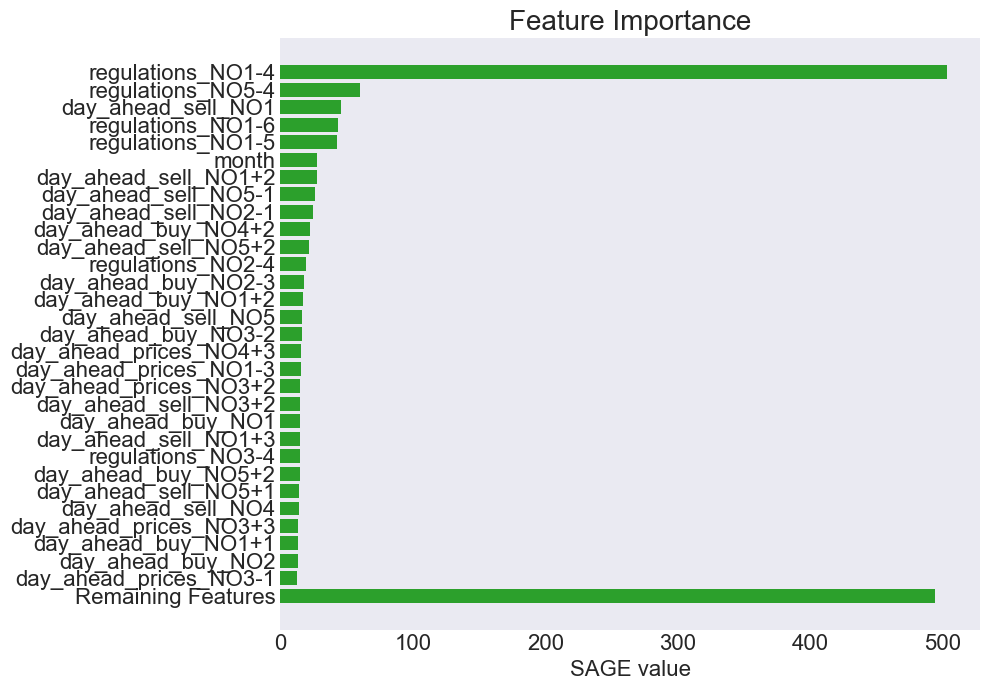

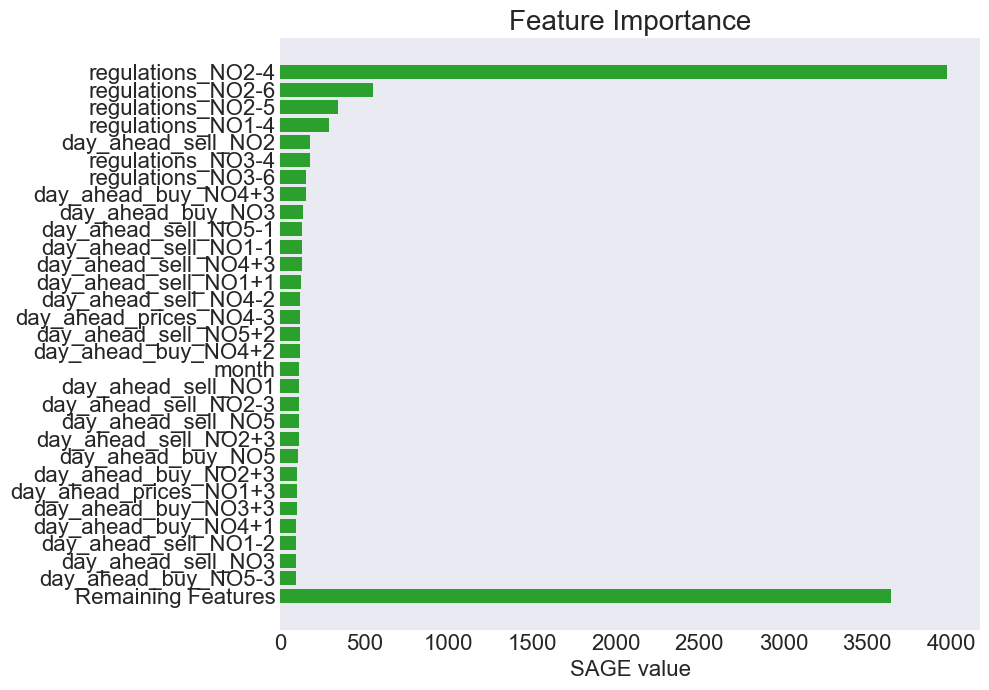

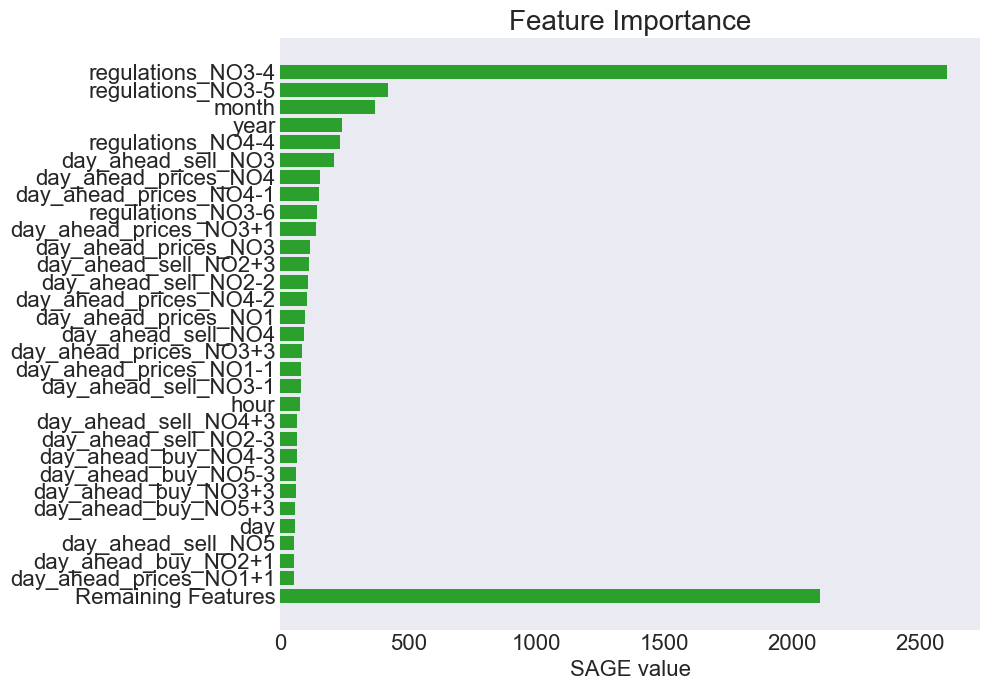

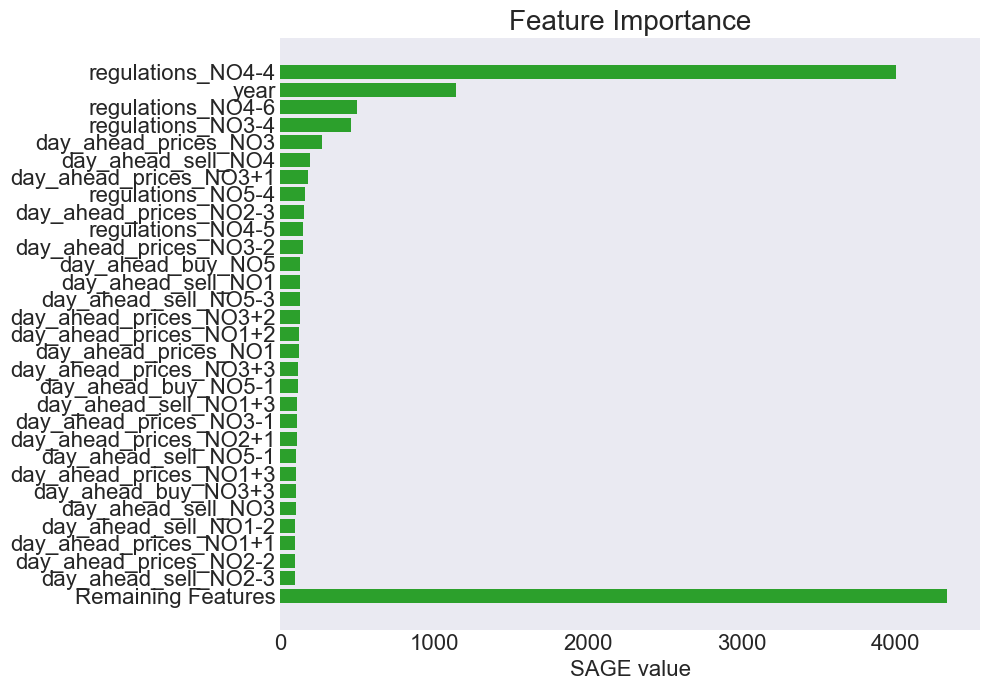

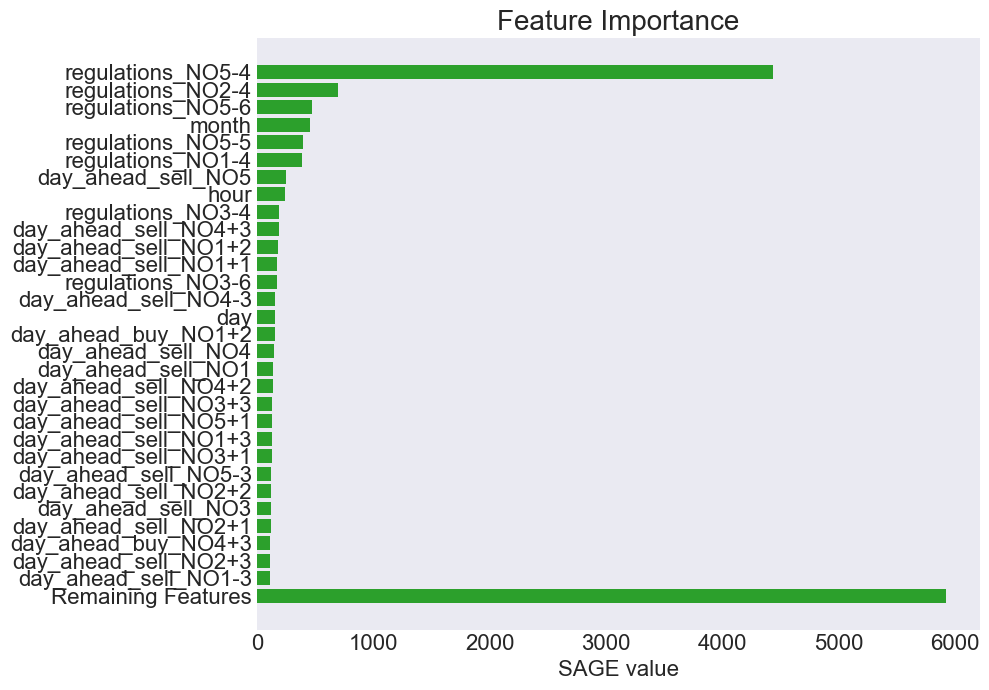

In [7]:
plt.rcParams["figure.figsize"] = (16,8)
results = []
for i, zone in enumerate(y.columns):
    print(f'------------Zone: {zone}-------------')

    # Get arguments of all hours with zero-regulation and non-zero regulation
    zero_arg = np.argwhere(X[zone].values==0).flatten()
    non_zero_arg = np.argwhere(X[zone].values!=0).flatten()

    # Get nb of hours with zero-regulation and non-zero regulation
    nb_zeros = len(X[zone][X[zone]==0])
    nb_non_zeros = len(X[zone][X[zone]!=0])

    ratio=2 # ratio of wanted non-zero to zero hours

    # randomly sample across the zero-hour regulation
    random_zero_index = np.random.choice(zero_arg, replace=False, size=min(int(nb_non_zeros/ratio), nb_zeros))
    # Concatenate arguments for non-zero and randomly selected zero regulation hours
    random_index = np.append(random_zero_index, non_zero_arg)
    X_temp = X.iloc[random_index,:].copy()
    y_temp = X_temp[zone].copy()
    X_temp = X_temp.drop(['regulations_NO1','regulations_NO2','regulations_NO3','regulations_NO4',
                          'regulations_NO5'], axis=1)
    
    model = XGBRegressor(n_estimators=400, max_depth=15, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42,shuffle=True)
    model = model.fit(X_train, y_train)
    print(model.score(X_test,y_test))
    #plot_importance(model, )
    results.append(sage_calc(X_test, y_test, X_test.columns, model))
    #if(i==0):
        #break

# Calculate metrics

In [8]:
X = df.copy()

X = X[['day_ahead_prices_NO1','day_ahead_prices_NO2','day_ahead_prices_NO3',
       'day_ahead_prices_NO4','day_ahead_prices_NO5',
       'regulations_NO1','regulations_NO2','regulations_NO3','regulations_NO4','regulations_NO5',
       'year','month','day','hour',
      'day_ahead_sell_NO1','day_ahead_sell_NO2','day_ahead_sell_NO3',
       'day_ahead_sell_NO4','day_ahead_sell_NO5',
      'day_ahead_buy_NO1','day_ahead_buy_NO2','day_ahead_buy_NO3',
      'day_ahead_buy_NO4','day_ahead_buy_NO5']]



for i in range(1,6):
    # t and t-4 for day-ahead values
    X[f'day_ahead_prices_NO{i}+1'] = X[f'day_ahead_prices_NO{i}'].shift(-1)
    X[f'day_ahead_prices_NO{i}+2'] = X[f'day_ahead_prices_NO{i}'].shift(-2)
    X[f'day_ahead_prices_NO{i}+3'] = X[f'day_ahead_prices_NO{i}'].shift(-3)
    X[f'day_ahead_prices_NO{i}-1'] = X[f'day_ahead_prices_NO{i}'].shift(1)
    X[f'day_ahead_prices_NO{i}-2'] = X[f'day_ahead_prices_NO{i}'].shift(2)
    X[f'day_ahead_prices_NO{i}-3'] = X[f'day_ahead_prices_NO{i}'].shift(3)

    X[f'day_ahead_sell_NO{i}+1'] = X[f'day_ahead_sell_NO{i}'].shift(-1)
    X[f'day_ahead_sell_NO{i}+2'] = X[f'day_ahead_sell_NO{i}'].shift(-2)
    X[f'day_ahead_sell_NO{i}+3'] = X[f'day_ahead_sell_NO{i}'].shift(-3)
    X[f'day_ahead_sell_NO{i}-1'] = X[f'day_ahead_sell_NO{i}'].shift(1)
    X[f'day_ahead_sell_NO{i}-2'] = X[f'day_ahead_sell_NO{i}'].shift(2)
    X[f'day_ahead_sell_NO{i}-3'] = X[f'day_ahead_sell_NO{i}'].shift(3)
    
    X[f'day_ahead_buy_NO{i}+1'] = X[f'day_ahead_buy_NO{i}'].shift(-1)
    X[f'day_ahead_buy_NO{i}+2'] = X[f'day_ahead_buy_NO{i}'].shift(-2)
    X[f'day_ahead_buy_NO{i}+3'] = X[f'day_ahead_buy_NO{i}'].shift(-3)
    X[f'day_ahead_buy_NO{i}-1'] = X[f'day_ahead_buy_NO{i}'].shift(1)
    X[f'day_ahead_buy_NO{i}-2'] = X[f'day_ahead_buy_NO{i}'].shift(2)
    X[f'day_ahead_buy_NO{i}-3'] = X[f'day_ahead_buy_NO{i}'].shift(3)

    # t-4 for regulation market
    X[f'regulations_NO{i}-4'] = df[f'regulations_NO{i}'].shift(4)
    X[f'regulations_NO{i}-5'] = df[f'regulations_NO{i}'].shift(5)
    X[f'regulations_NO{i}-6'] = df[f'regulations_NO{i}'].shift(6)

X = X.dropna()
y = X[['regulations_NO1','regulations_NO2','regulations_NO3',
       'regulations_NO4','regulations_NO5']].copy()
X = X.drop(['regulations_NO1','regulations_NO2','regulations_NO3',
       'regulations_NO4','regulations_NO5'], axis=1)
results_names = []
for i, zone in enumerate(y.columns):
    print(f'------------Zone: {zone}-------------')
    y_temp = y[zone].copy()

    X_temp = X.copy()
    
    results_names.append(X_temp.columns)

C:\Users\forraust\AppData\Local\Temp\ipykernel_28764\4012678744.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'day_ahead_buy_NO{i}+3'] = X[f'day_ahead_buy_NO{i}'].shift(-3)
C:\Users\forraust\AppData\Local\Temp\ipykernel_28764\4012678744.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'day_ahead_buy_NO{i}-1'] = X[f'day_ahead_buy_NO{i}'].shift(1)
C:\Users\forraust\AppData\Local\Temp\ipykernel_28764\4012678744.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

------------Zone: regulations_NO1-------------
------------Zone: regulations_NO2-------------
------------Zone: regulations_NO3-------------
------------Zone: regulations_NO4-------------
------------Zone: regulations_NO5-------------


In [9]:
results

[SAGE Explanation(
   (Mean): [ 10.95  11.04   8.57 ...  60.20 -12.33  -7.74]
   (Std):  [1.90 1.00 1.26 ... 3.94 1.01 1.41]
 ),
 SAGE Explanation(
   (Mean): [ 62.49  57.99  73.81 ...  82.70 -61.12  91.11]
   (Std):  [12.85 12.75 11.73 ... 18.33  9.75  7.47]
 ),
 SAGE Explanation(
   (Mean): [ 96.02  36.99 115.37 ...  37.54  11.74  34.09]
   (Std):  [10.27  4.19  8.23 ...  5.36  4.38  3.22]
 ),
 SAGE Explanation(
   (Mean): [119.11  60.63 269.50 ... 160.85  23.99  32.90]
   (Std):  [12.43  7.13 13.33 ...  9.30  5.75  4.22]
 ),
 SAGE Explanation(
   (Mean): [ 107.13   46.50  109.53 ... 4438.28  397.98  474.28]
   (Std):  [ 13.13  10.48  12.54 ... 110.65  25.18  22.60]
 )]

In [10]:
res_matrix_sorted = np.zeros((5,len(results_names[0])))
res_matrix_sorted_std = np.zeros((5,len(results_names[0])))

res_names_sorted = []
for i in range(5):
    mask = np.argsort(results[i].values)[::-1]
    res_matrix_sorted[i,:] = results[i].values[mask]
    res_names_sorted.append(results_names[i][mask])
    
    #std and normalize
    res_matrix_sorted_std[i,:] = results[i].std[mask]
    res_matrix_sorted_std[i,:] = res_matrix_sorted_std[i,:]/np.max(res_matrix_sorted[i,:])
    res_matrix_sorted[i,:] = res_matrix_sorted[i,:]/np.max(res_matrix_sorted[i,:])


In [11]:
res_matrix_agg_mean = np.zeros((5,10))
res_matrix_agg_std = np.zeros((5,10))
for i in range(5):
    res_matrix_agg_mean[i,0:9] = res_matrix_sorted[i,0:9]
    res_matrix_agg_mean[i,9] = np.sum(res_matrix_sorted[i,10:])
    res_matrix_agg_std[i,0:9] = res_matrix_sorted_std[i,0:9]
    res_matrix_agg_std[i,9] = np.sum(res_matrix_sorted_std[i,10:])

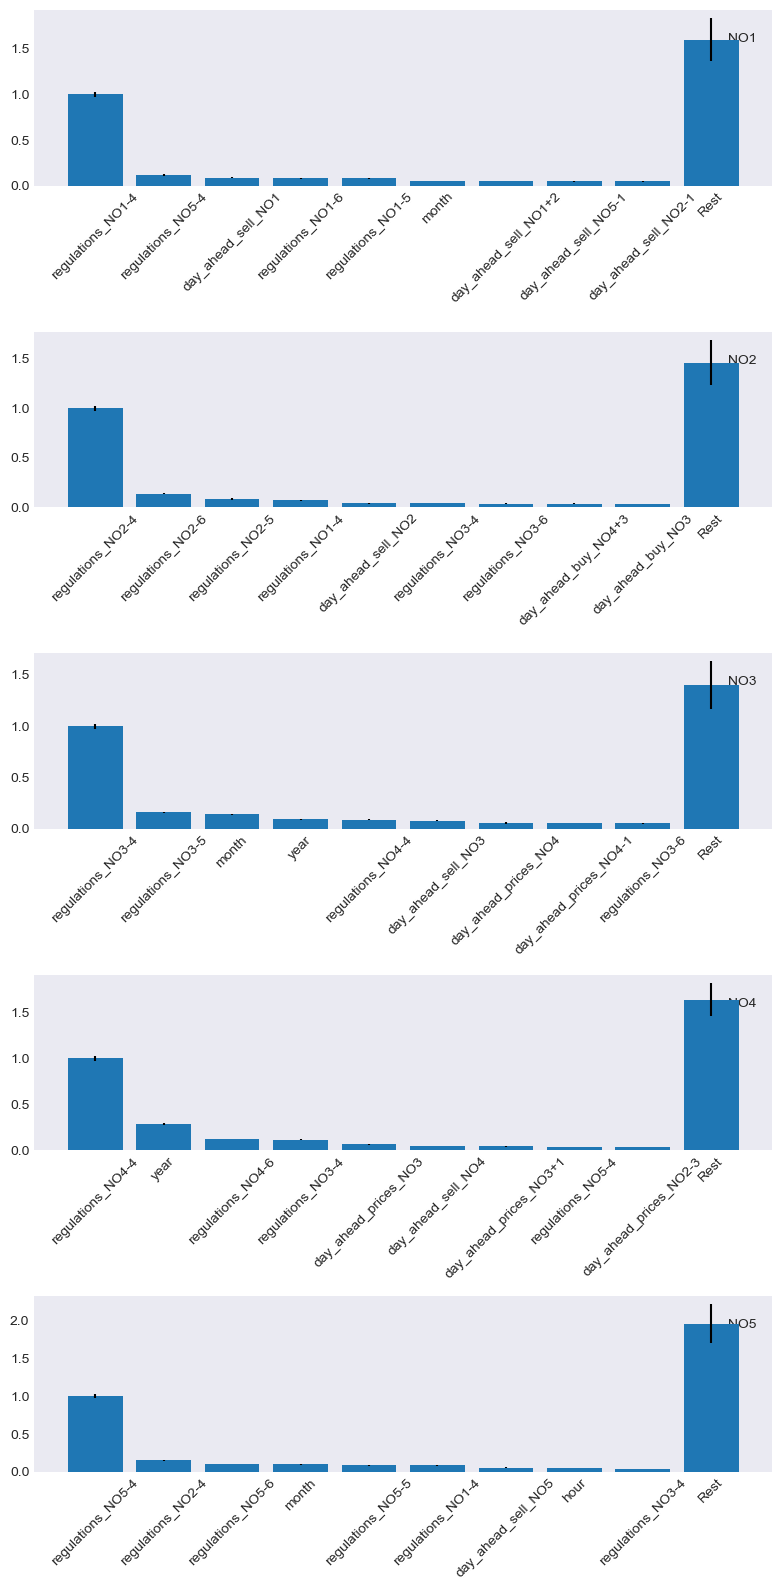

In [12]:
plt.rcParams["figure.figsize"] = (8,16)

fig, ax = plt.subplots(nrows=5, ncols=1)

for i in range(5):
    ax[i].bar(res_names_sorted[i][0:10], res_matrix_agg_mean[i][0:10], label=f'NO{i+1}', yerr=res_matrix_agg_std[i][0:10])
    ax[i].set_ylabel(f'NO{i+1}', rotation=0)
    ax[i].yaxis.set_label_coords(0.96,0.8)
    ax[i].set_xticks(res_names_sorted[i][0:10])
    
    names_temp = list(res_names_sorted[i][0:9])
    names_temp.append('Rest')
    ax[i].set_xticklabels(names_temp, rotation = 45)
    #ax[i].legend(loc='upper right')

fig.tight_layout() 
fig.savefig('feature_importances.png', dpi=fig.dpi)


In [13]:
for i in range(5):
    print(f'Zone NO{i+1}')
    print(np.round(res_matrix_agg_mean[i,:], 2))
    print(res_names_sorted[i][0:10])

Zone NO1
[1.   0.12 0.09 0.09 0.09 0.05 0.05 0.05 0.05 1.6 ]
Index(['regulations_NO1-4', 'regulations_NO5-4', 'day_ahead_sell_NO1',
       'regulations_NO1-6', 'regulations_NO1-5', 'month',
       'day_ahead_sell_NO1+2', 'day_ahead_sell_NO5-1', 'day_ahead_sell_NO2-1',
       'day_ahead_buy_NO4+2'],
      dtype='object')
Zone NO2
[1.   0.14 0.09 0.07 0.04 0.04 0.04 0.04 0.03 1.46]
Index(['regulations_NO2-4', 'regulations_NO2-6', 'regulations_NO2-5',
       'regulations_NO1-4', 'day_ahead_sell_NO2', 'regulations_NO3-4',
       'regulations_NO3-6', 'day_ahead_buy_NO4+3', 'day_ahead_buy_NO3',
       'day_ahead_sell_NO5-1'],
      dtype='object')
Zone NO3
[1.   0.16 0.14 0.09 0.09 0.08 0.06 0.06 0.06 1.4 ]
Index(['regulations_NO3-4', 'regulations_NO3-5', 'month', 'year',
       'regulations_NO4-4', 'day_ahead_sell_NO3', 'day_ahead_prices_NO4',
       'day_ahead_prices_NO4-1', 'regulations_NO3-6',
       'day_ahead_prices_NO3+1'],
      dtype='object')
Zone NO4
[1.   0.28 0.12 0.11 0.07 0.05